In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import glob
from IPython.display import display

In [3]:
benchmark_results = []
for path in glob.glob('../../benchmarks/2020-12-15-add-remove-small-regen-1/*.csv'):
    benchmark_results.append(pd.read_csv(path))
benchmark_results = pd.concat(benchmark_results)

benchmark_results.sample(5)

,generation_config_i,input_strategy,input_length_1,input_change_strength,input_chunkiness,input_distribution,regen_i,repetition_i,diff_program,mpi_procs,timeout_seconds,mpi_comm_world,micros_input,micros_precompute,micros_until_len,micros_edit_script,min_edit_length
4390,22,addremove,100000,0.3,0.5,zipf,0,8,mpi_priority_frontier_simd,32.0,60.0,32,22689,0,164705,0,44413
1096,52,add,128000,0.3,0.5,zipf,0,4,mpi_no_master_frontier_simd,2.0,60.0,2,29114,0,2163798,0,38400
3242,209,addremove,212000,0.5,1.0,zipf,0,5,mpi_priority_frontier_simd,32.0,60.0,32,36651,0,1158213,0,154028
510,150,addremove,184000,0.1,0.0,zipf,0,6,mpi_priority_frontier,32.0,60.0,32,28419,0,102833,0,33418
1076,21,addremove,100000,0.3,0.0,zipf,0,18,mpi_no_master_frontier,64.0,60.0,64,1163548,0,75197,0,45910


In [4]:
def agg_all_same(values):
    # assert (values == values.iloc[0]).all()
    return values.iloc[0]

def prepare_plot_data(filter_cb, index):
    temp = benchmark_results.copy()
    temp['mpi_procs'] = temp['mpi_procs'].fillna('sequential')
    temp = temp.groupby(['generation_config_i', 'mpi_procs', 'diff_program']).agg({
        'input_strategy': agg_all_same,
        'input_length_1': agg_all_same,
        'min_edit_length': agg_all_same,
        'input_change_strength': agg_all_same,
        'input_chunkiness': agg_all_same,
        'repetition_i': 'max',
        'micros_until_len': 'median',
    })
    temp = filter_cb(temp)
    temp = temp.set_index(index, append=True)
    temp = temp.unstack('mpi_procs')['micros_until_len']
    temp = temp.droplevel('generation_config_i')
    temp = temp.sort_index()
    return temp

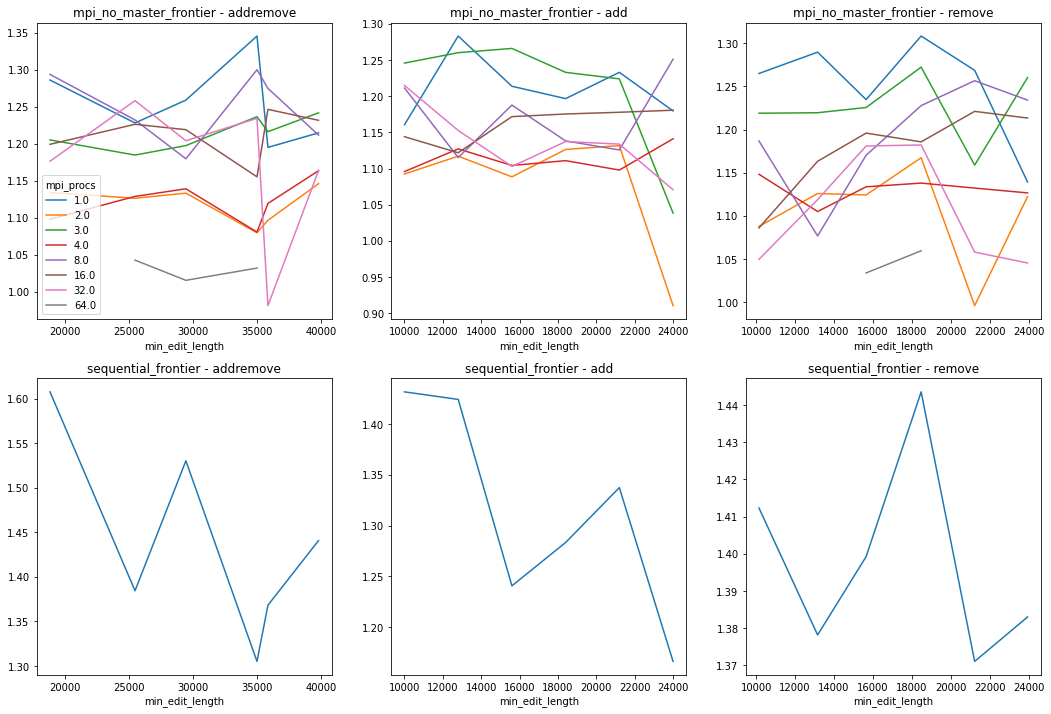

In [43]:
fig, ax = plt.subplots(2, 3, figsize=(18, 12), sharex=False, sharey=False)
for diff_program_i, diff_program in enumerate(['mpi_no_master_frontier', 'sequential_frontier']):
    for input_strategy_i, input_strategy in enumerate(['addremove', 'add', 'remove']):
        if diff_program == 'mpi_priority_frontier':
            rep_max = 19
        else:
            rep_max = 49

        no_simd = prepare_plot_data(
            lambda temp: temp[(temp.index.get_level_values('diff_program') == diff_program) & (temp['input_strategy'] == input_strategy) & (temp['input_change_strength'] == temp['input_change_strength'].min()) & (temp['input_chunkiness'] == temp['input_chunkiness'].max()) & (temp['repetition_i'] != rep_max)],
            'min_edit_length',
        )
        simd = prepare_plot_data(
            lambda temp: temp[(temp.index.get_level_values('diff_program') == diff_program + "_simd") & (temp['input_strategy'] == input_strategy) & (temp['input_change_strength'] == temp['input_change_strength'].min()) & (temp['input_chunkiness'] == temp['input_chunkiness'].max()) & (temp['repetition_i'] != rep_max)],
            'min_edit_length',
        )
        no_simd = no_simd.droplevel('diff_program')
        simd = simd.droplevel('diff_program')
        
        (no_simd / simd).plot(ax=ax[diff_program_i][input_strategy_i], legend=(input_strategy_i == 0 and diff_program_i == 0), title=f'{diff_program} - {input_strategy}');
        # TODO: exclude test cases with repetitions = 50 / 20

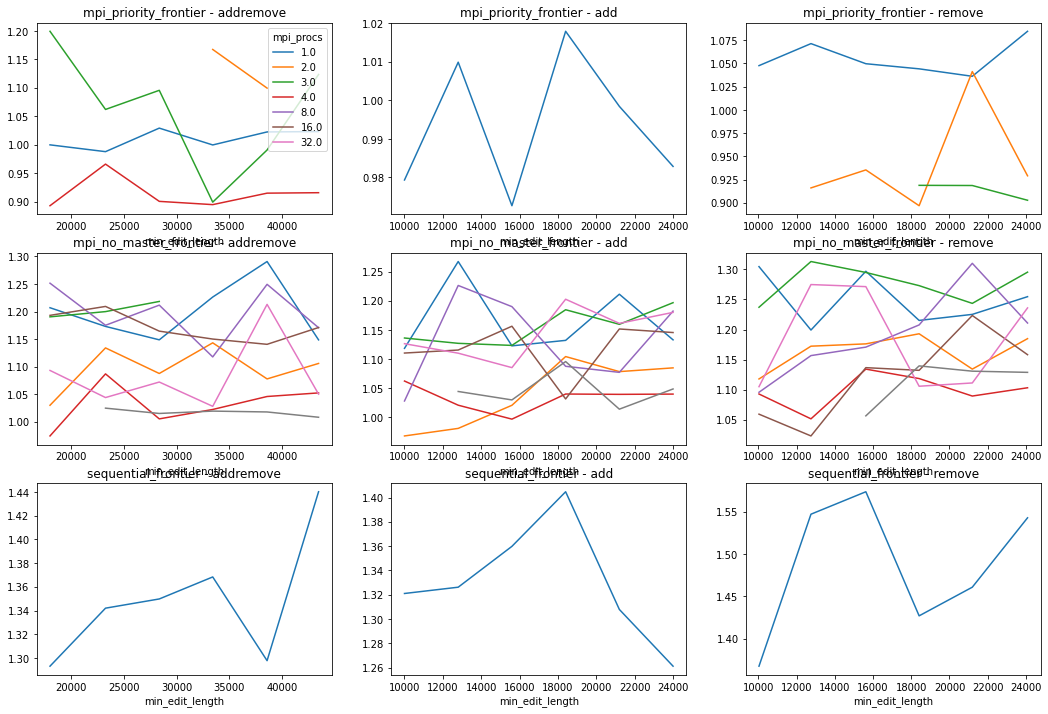

In [45]:
fig, ax = plt.subplots(3, 3, figsize=(18, 12), sharex=False, sharey=False)
for diff_program_i, diff_program in enumerate(['mpi_priority_frontier', 'mpi_no_master_frontier', 'sequential_frontier']):
    for input_strategy_i, input_strategy in enumerate(['addremove', 'add', 'remove']):
        if diff_program == 'mpi_priority_frontier':
            rep_max = 19
        else:
            rep_max = 49

        no_simd = prepare_plot_data(
            lambda temp: temp[(temp.index.get_level_values('diff_program') == diff_program) & (temp['input_strategy'] == input_strategy) & (temp['input_change_strength'] == temp['input_change_strength'].min()) & (temp['input_chunkiness'] == temp['input_chunkiness'].min()) & (temp['repetition_i'] != rep_max)],
            'min_edit_length',
        )
        simd = prepare_plot_data(
            lambda temp: temp[(temp.index.get_level_values('diff_program') == diff_program + "_simd") & (temp['input_strategy'] == input_strategy) & (temp['input_change_strength'] == temp['input_change_strength'].min()) & (temp['input_chunkiness'] == temp['input_chunkiness'].min()) & (temp['repetition_i'] != rep_max)],
            'min_edit_length',
        )
        no_simd = no_simd.droplevel('diff_program')
        simd = simd.droplevel('diff_program')
        
        (no_simd / simd).plot(ax=ax[diff_program_i][input_strategy_i], legend=(input_strategy_i == 0 and diff_program_i == 0), title=f'{diff_program} - {input_strategy}');

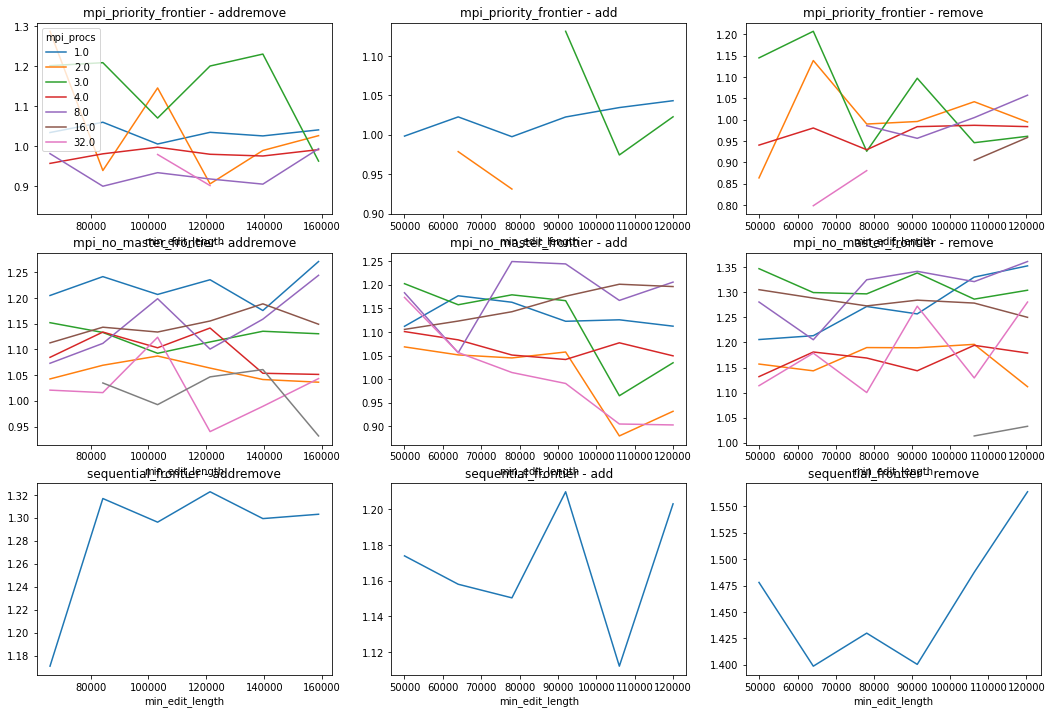

In [46]:
fig, ax = plt.subplots(3, 3, figsize=(18, 12), sharex=False, sharey=False)
for diff_program_i, diff_program in enumerate(['mpi_priority_frontier', 'mpi_no_master_frontier', 'sequential_frontier']):
    for input_strategy_i, input_strategy in enumerate(['addremove', 'add', 'remove']):
        if diff_program == 'mpi_priority_frontier':
            rep_max = 19
        else:
            rep_max = 49

        no_simd = prepare_plot_data(
            lambda temp: temp[(temp.index.get_level_values('diff_program') == diff_program) & (temp['input_strategy'] == input_strategy) & (temp['input_change_strength'] == temp['input_change_strength'].max()) & (temp['input_chunkiness'] == temp['input_chunkiness'].min()) & (temp['repetition_i'] != rep_max)],
            'min_edit_length',
        )
        simd = prepare_plot_data(
            lambda temp: temp[(temp.index.get_level_values('diff_program') == diff_program + "_simd") & (temp['input_strategy'] == input_strategy) & (temp['input_change_strength'] == temp['input_change_strength'].max()) & (temp['input_chunkiness'] == temp['input_chunkiness'].min()) & (temp['repetition_i'] != rep_max)],
            'min_edit_length',
        )
        no_simd = no_simd.droplevel('diff_program')
        simd = simd.droplevel('diff_program')
        
        (no_simd / simd).plot(ax=ax[diff_program_i][input_strategy_i], legend=(input_strategy_i == 0 and diff_program_i == 0), title=f'{diff_program} - {input_strategy}');

mpi_priority_frontier add & remove:
0.5088300220750552
mpi_no_master_frontier add & remove:
0.9453740157480315
sequential_frontier add & remove:
1.0


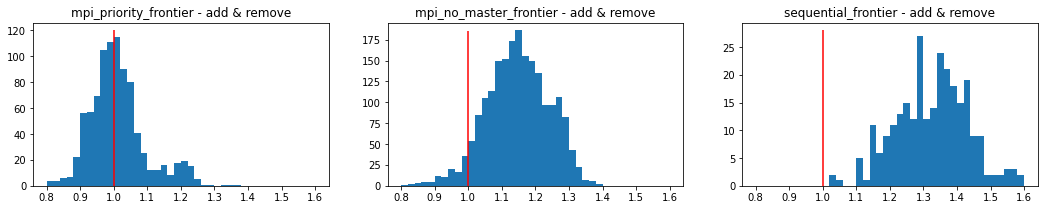

In [145]:
fig, ax = plt.subplots(1, 3, figsize=(18, 3), sharex=False, sharey=False)
for diff_program_i, diff_program in enumerate(['mpi_priority_frontier', 'mpi_no_master_frontier', 'sequential_frontier']):

    if diff_program == 'mpi_priority_frontier':
        rep_max = 19
    else:
        rep_max = 49

    no_simd = benchmark_results[(benchmark_results['diff_program'] == diff_program)].copy()
    no_simd['mpi_procs'] = no_simd['mpi_procs'].fillna('sequential')
    no_simd = no_simd.groupby(['generation_config_i', 'mpi_procs']).agg({
        'repetition_i': 'max',
        'micros_until_len': 'median',
    })

    simd = benchmark_results[(benchmark_results['diff_program'] == diff_program + "_simd")].copy()
    simd['mpi_procs'] = simd['mpi_procs'].fillna('sequential')
    simd = simd.groupby(['generation_config_i', 'mpi_procs']).agg({
        'repetition_i': 'max',
        'micros_until_len': 'median',
    })

    confidence_filter = (no_simd['repetition_i'] != rep_max) & (simd ['repetition_i'] != rep_max)     # exclude values with lower confidence

    no_simd = no_simd[confidence_filter]['micros_until_len']
    simd = simd[confidence_filter]['micros_until_len']


    print(diff_program + " add & remove:")
    print((simd < no_simd).mean())

    hist_values = no_simd / simd
    
    #hist_values = hist_values[(hist_values < 50) & (temp.sequential > 1000)]
    ax[diff_program_i].set_title(f'{diff_program} - add & remove')
    if diff_program == 'mpi_priority_frontier':
            hist_max = 120
    else:
        if diff_program == 'mpi_no_master_frontier':
            hist_max = 185
        else:
            hist_max = 28
    ax[diff_program_i].vlines(1, 0, hist_max, colors=['Red'])
    ax[diff_program_i].hist(hist_values, bins=40, range=(0.8, 1.6));


mpi_priority_frontier add & remove:
0.4528301886792453
mpi_priority_frontier add & remove:
0.5
mpi_priority_frontier add & remove:
0.5771812080536913
mpi_no_master_frontier add & remove:
0.9455081001472754
mpi_no_master_frontier add & remove:
0.9243323442136498
mpi_no_master_frontier add & remove:
0.9661266568483063
sequential_frontier add & remove:
1.0
sequential_frontier add & remove:
1.0
sequential_frontier add & remove:
1.0


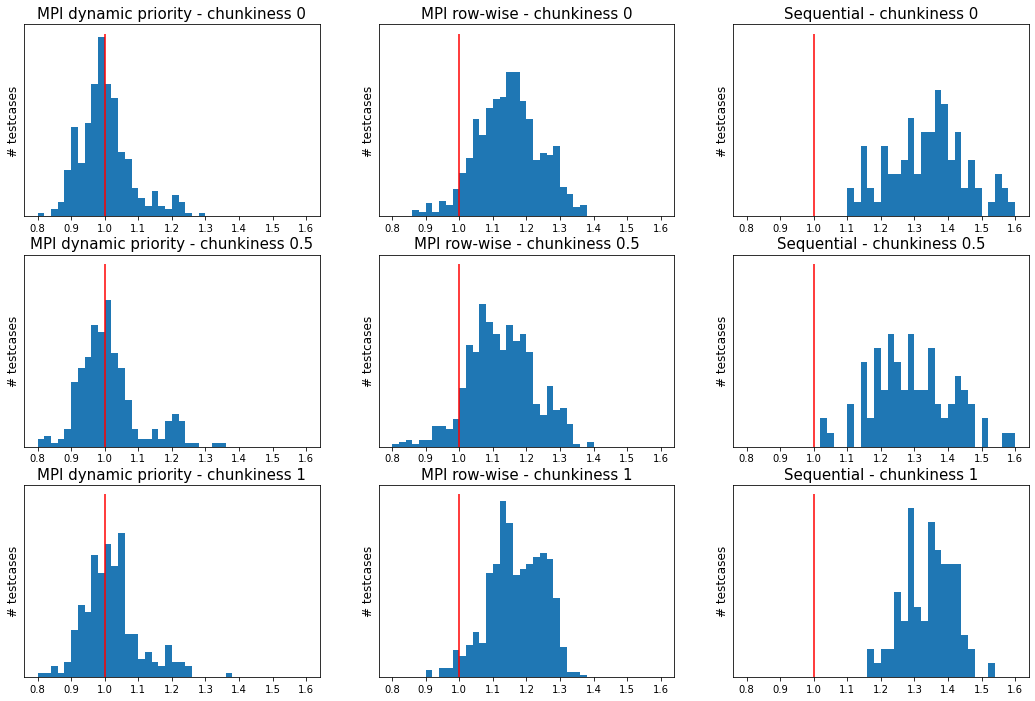

In [16]:
# different chunkiness

fig, ax = plt.subplots(3, 3, figsize=(18, 12), sharex=False, sharey='col')
for diff_program_i, diff_program in enumerate(['mpi_priority_frontier', 'mpi_no_master_frontier', 'sequential_frontier']):
    for input_chunkiness_i, input_chunkiness in enumerate([0, 0.5, 1]):

        if diff_program == 'mpi_priority_frontier':
            rep_max = 19
        else:
            rep_max = 49

        no_simd = benchmark_results[(benchmark_results['diff_program'] == diff_program) & (benchmark_results['input_chunkiness'] == input_chunkiness)].copy()
        no_simd['mpi_procs'] = no_simd['mpi_procs'].fillna('sequential')
        no_simd = no_simd.groupby(['generation_config_i', 'mpi_procs']).agg({
            'repetition_i': 'max',
            'micros_until_len': 'median',
        })

        simd = benchmark_results[(benchmark_results['diff_program'] == diff_program + "_simd")].copy()
        simd['mpi_procs'] = simd['mpi_procs'].fillna('sequential')
        simd = simd.groupby(['generation_config_i', 'mpi_procs']).agg({
            'repetition_i': 'max',
            'micros_until_len': 'median',
        })

        confidence_filter = (no_simd['repetition_i'] != rep_max) & (simd ['repetition_i'] != rep_max)     # exclude values with lower confidence

        no_simd = no_simd[confidence_filter]['micros_until_len']
        simd = simd[confidence_filter]['micros_until_len']


        print(diff_program + " add & remove:")
        print((simd < no_simd).mean())

        hist_values = no_simd / simd
        
        #hist_values = hist_values[(hist_values < 50) & (temp.sequential > 1000)]
        this_ax = ax[input_chunkiness_i][diff_program_i]

        if diff_program == 'mpi_priority_frontier':
            hist_max = 51
            title_name = "MPI dynamic priority"
        else:
            if diff_program == 'mpi_no_master_frontier':
                hist_max = 81
                title_name = "MPI row-wise"
            else:
                hist_max = 13
                title_name = 'Sequential'
        
        this_ax.set_title(f'{title_name} - chunkiness {input_chunkiness}', fontsize=15)
        this_ax.vlines(1, 0, hist_max, colors=['Red'])
        this_ax.hist(hist_values, bins=40, range=(0.8, 1.6))
        this_ax.set_yticks([])
        this_ax.set_ylabel('# testcases', fontsize=12)

#fig.savefig("/mnt/c/Users/Lowis/Downloads/add_remove_9x9_simd_hists.png", dpi=300, transparent=True)

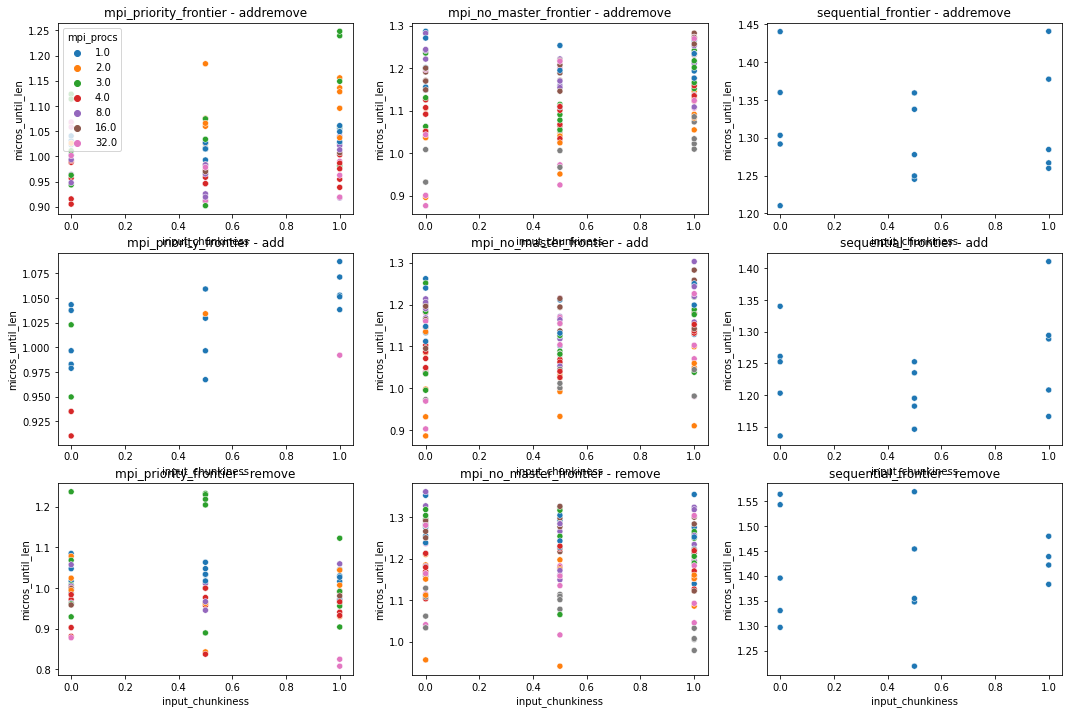

In [126]:
palette = {mpi_procs: color for mpi_procs, color in zip(sorted(benchmark_results.mpi_procs.dropna().unique()), sns.color_palette())}
fig, ax = plt.subplots(3, 3, figsize=(18, 12), sharex=False, sharey=False)
for diff_program_i, diff_program in enumerate(['mpi_priority_frontier', 'mpi_no_master_frontier', 'sequential_frontier']):
    for input_strategy_i, input_strategy in enumerate(['addremove', 'add', 'remove']):

        if diff_program == 'mpi_priority_frontier':
            rep_max = 19
        else:
            rep_max = 49

        no_simd = benchmark_results[(benchmark_results['diff_program'] == diff_program) & (benchmark_results['input_strategy'] == input_strategy) & (benchmark_results['input_length_1'] == benchmark_results['input_length_1'].max())].copy()
        no_simd['mpi_procs'] = no_simd['mpi_procs'].fillna(1)
        no_simd = no_simd.groupby(['generation_config_i', 'mpi_procs', 'input_chunkiness']).agg({
            'repetition_i': 'max',
            'micros_until_len': 'median',
        })

        simd = benchmark_results[(benchmark_results['diff_program'] == diff_program + "_simd") & (benchmark_results['input_strategy'] == input_strategy)].copy()
        simd['mpi_procs'] = simd['mpi_procs'].fillna(1)
        simd = simd.groupby(['generation_config_i', 'mpi_procs', 'input_chunkiness']).agg({
            'repetition_i': 'max',
            'micros_until_len': 'median',
        })

        confidence_filter = (no_simd['repetition_i'] != rep_max) & (simd['repetition_i'] != rep_max)     # exclude values with lower confidence

        no_simd = no_simd[confidence_filter].drop('repetition_i', 1)
        simd = simd[confidence_filter].drop('repetition_i', 1)

        temp = no_simd / simd

        #print(temp)

        this_ax = ax[input_strategy_i][diff_program_i]
        this_ax.set_title(f'{diff_program} - {input_strategy}')
        sns.scatterplot(data=temp, x='input_chunkiness', y='micros_until_len', hue='mpi_procs', palette=palette, ax=this_ax, legend=(diff_program_i == 0 and input_strategy_i == 0));

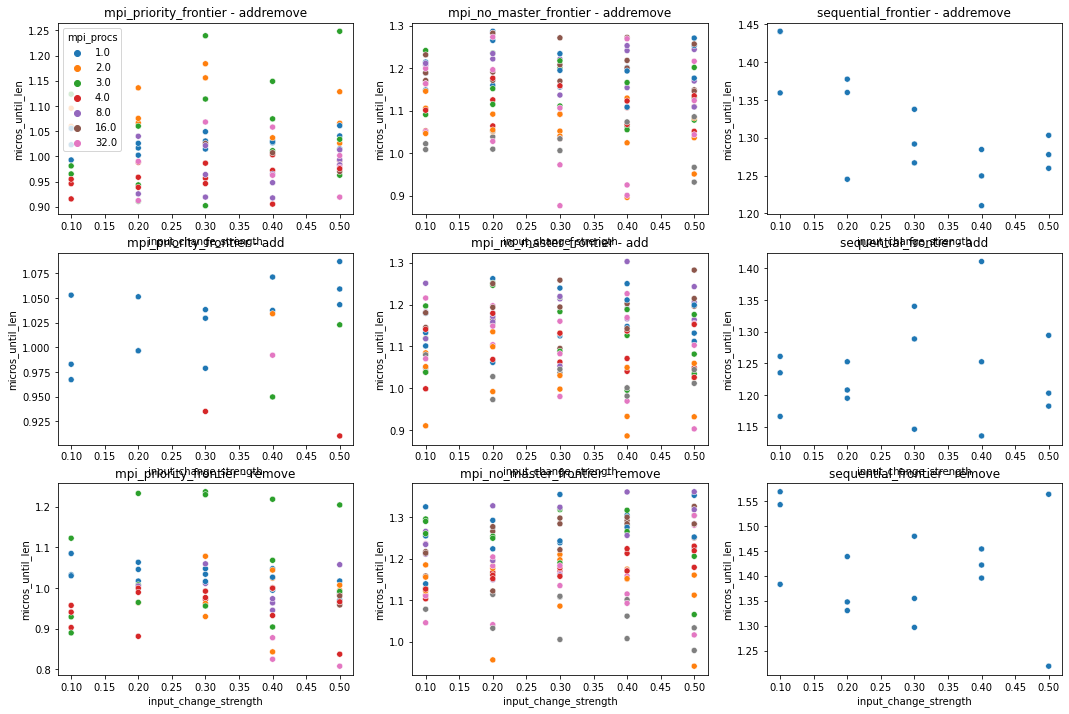

In [127]:
palette = {mpi_procs: color for mpi_procs, color in zip(sorted(benchmark_results.mpi_procs.dropna().unique()), sns.color_palette())}
fig, ax = plt.subplots(3, 3, figsize=(18, 12), sharex=False, sharey=False)
for diff_program_i, diff_program in enumerate(['mpi_priority_frontier', 'mpi_no_master_frontier', 'sequential_frontier']):
    for input_strategy_i, input_strategy in enumerate(['addremove', 'add', 'remove']):

        if diff_program == 'mpi_priority_frontier':
            rep_max = 19
        else:
            rep_max = 49

        no_simd = benchmark_results[(benchmark_results['diff_program'] == diff_program) & (benchmark_results['input_strategy'] == input_strategy) & (benchmark_results['input_length_1'] == benchmark_results['input_length_1'].max())].copy()
        no_simd['mpi_procs'] = no_simd['mpi_procs'].fillna(1)
        no_simd = no_simd.groupby(['generation_config_i', 'mpi_procs', 'input_change_strength']).agg({
            'repetition_i': 'max',
            'micros_until_len': 'median',
        })

        simd = benchmark_results[(benchmark_results['diff_program'] == diff_program + "_simd") & (benchmark_results['input_strategy'] == input_strategy)].copy()
        simd['mpi_procs'] = simd['mpi_procs'].fillna(1)
        simd = simd.groupby(['generation_config_i', 'mpi_procs', 'input_change_strength']).agg({
            'repetition_i': 'max',
            'micros_until_len': 'median',
        })

        confidence_filter = (no_simd['repetition_i'] != rep_max) & (simd['repetition_i'] != rep_max)     # exclude values with lower confidence

        no_simd = no_simd[confidence_filter].drop('repetition_i', 1)
        simd = simd[confidence_filter].drop('repetition_i', 1)

        temp = no_simd / simd

        #print(temp)

        this_ax = ax[input_strategy_i][diff_program_i]
        this_ax.set_title(f'{diff_program} - {input_strategy}')
        sns.scatterplot(data=temp, x='input_change_strength', y='micros_until_len', hue='mpi_procs', palette=palette, ax=this_ax, legend=(diff_program_i == 0 and input_strategy_i == 0));

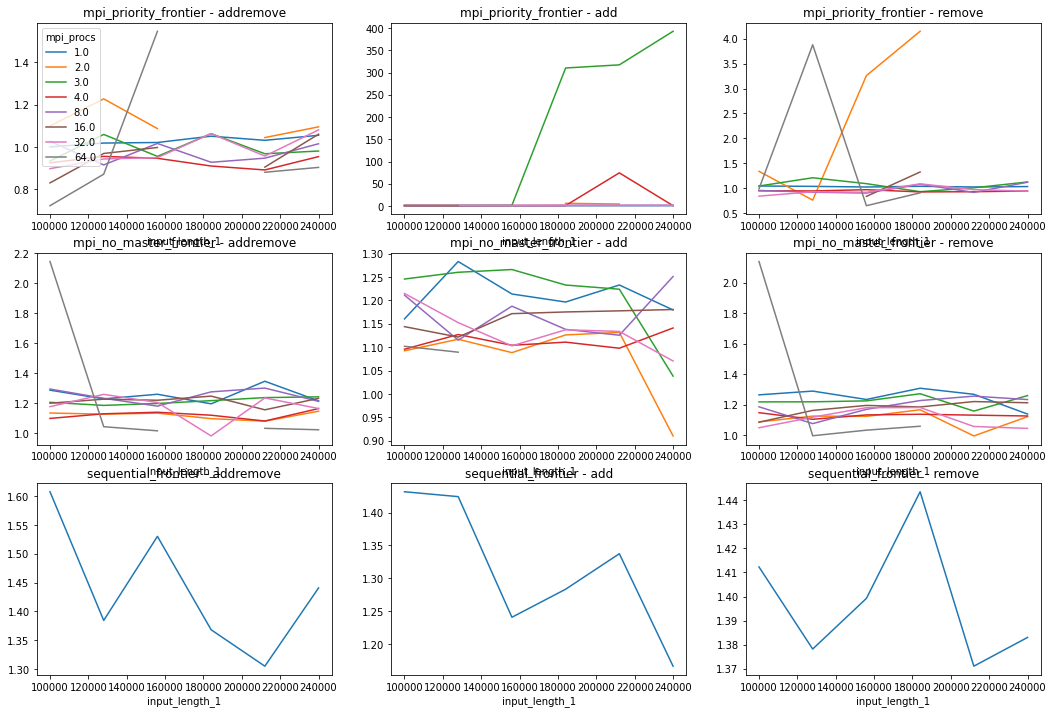

In [11]:
fig, ax = plt.subplots(3, 3, figsize=(18, 12), sharex=False, sharey=False)
for diff_program_i, diff_program in enumerate(['mpi_priority_frontier', 'mpi_no_master_frontier', 'sequential_frontier']):
    for input_strategy_i, input_strategy in enumerate(['addremove', 'add', 'remove']):
        no_simd = prepare_plot_data(
            lambda temp: temp[(temp.index.get_level_values('diff_program') == diff_program) & (temp['input_strategy'] == input_strategy) & (temp['input_change_strength'] == temp['input_change_strength'].min()) & (temp['input_chunkiness'] == temp['input_chunkiness'].max())],
            'input_length_1',
        )
        simd = prepare_plot_data(
            lambda temp: temp[(temp.index.get_level_values('diff_program') == diff_program + "_simd") & (temp['input_strategy'] == input_strategy) & (temp['input_change_strength'] == temp['input_change_strength'].min()) & (temp['input_chunkiness'] == temp['input_chunkiness'].max())],
            'input_length_1',
        )
        no_simd = no_simd.droplevel('diff_program')
        simd = simd.droplevel('diff_program')
        
        (no_simd / simd).plot(ax=ax[diff_program_i][input_strategy_i], legend=(input_strategy_i == 0 and diff_program_i == 0), title=f'{diff_program} - {input_strategy}');